In [1]:
%matplotlib notebook
import concurrent.futures
import importlib
import os
import sys
from collections import Counter
from pprint import pprint

import imgaug.augmenters as iaa
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.color import label2rgb
from skimage.io import imread, imsave
from skimage.transform import resize
import pandas as pd

from mrcnn.model import MaskRCNN

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
DATA_DIR = "/home/users/khu/src/abyss/deep-learning/data"

Using TensorFlow backend.


# Load dataset

In [2]:
def setup_args():
    from keras.applications.resnet50 import preprocess_input
    from bidict import bidict
    from imgaug import augmenters as iaa
    from imgaug.parameters import Normal, Discretize
    from skimage.transform import resize
    
    def load_config(path):
        spec = importlib.util.spec_from_file_location(
            "maskrcnn_config", path)
        config_module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(config_module)
        return config_module.Config()

#     def preprocess_data(image):
#         '''Transform the image before (possibly caching) and input to the network.'''
#        # This is done automatically by MRCNN

    def postprocess_data(image):
        '''Inverse transform of preprocess_data, used when trying to visualize images out of the dataset.'''
        return (image + 127.5).astype(np.uint8)

    def pipeline(gen, aug_config=None):
        '''The pipeline to run the dataset generator through.'''
        from abyss_deep_learning.keras.classification import onehot_gen, augmentation_gen

        return gen 
#                 (
#             augmentation_gen(
#                 onehot_gen(gen, num_classes=args['num_classes'])
#             , aug_config, enable=(aug_config is not None))
#         )

    augmentation_config = iaa.Sequential([ 
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Affine(
            scale=(0.8, 1.2),
            translate_percent=(-0.2, 0.2), 
            rotate=(-22.5, 22.5),
            mode='constant', cval=0, order=0
        ),
        iaa.Sequential([ # Colour aug
            iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
            iaa.WithChannels(0, iaa.Add(Discretize(Normal(0, 256 / 6)))),
            iaa.WithChannels(1, iaa.Add(Discretize(Normal(0, 256 / 6)))),
            iaa.WithChannels(2, iaa.Add(Discretize(Normal(0, 256 / 6)))),
            iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")
        ])
    ])

    args = {
        'augmentation': None,#augmentation_config,    # Training augmentation
#         'caption_map': caption_map,             # Captio
        'data': {
            'base_dir': DATA_DIR,
            'name': ".",
            'sets': ['coco-segmentation']
        },
        'config': load_config(os.path.join(DATA_DIR, '../configs/MaskRCNN_default_config.py')),
        'image_dims': (1024, 1024, 3),    # What to resize images to before CNN
        'image_dir': DATA_DIR,          # Directory to use if relative image paths given
        'nn_dtype': np.float32,         # Pretrained networks are in float32
        'num_classes': None,            # Calculate later
#         'use_balanced_set': False,      # Force the use of the largest class-balanced dataset
#         'use_cached': False,            # Cache the dataset in memory
#         'use_class_weights': True,      # Use class population to weight in the training loss
#         'use_parallel': False,          # Use multiple GPUs
#         'preprocess_data': preprocess_data,
        'postprocess_data': postprocess_data,
        'pipeline': pipeline
    }
    args['config'].NUM_CLASSES = 7
    args['num_classes'] = args['config'].NUM_CLASSES
    
    return args
ARGS = setup_args()

# Setup Data

In [3]:
def setup_datasets(args):
    from abyss_deep_learning.datasets.coco import MaskRcnnInstSegDataset
    
    dataset = dict()
    for set_name in args['data']['sets']:
        path = os.path.join(args['data']['base_dir'], "{:s}/{:s}.json".format(args['data']['name'], set_name))
        dataset[set_name] = MaskRcnnInstSegDataset(
            path,
            ARGS['config'],
            image_dir=ARGS['image_dir'])
        print("\n", set_name)

    print("\nNumber of classes:", args['num_classes'])
    cats = dataset['coco-segmentation'].coco.loadCats(dataset['coco-segmentation'].coco.getCatIds())
    class_names = ["BG"] + [
        cat['name'] for cat in sorted(cats, key=lambda x: x['id'])]
    print(class_names)
    return dataset, class_names

DATASET, ARGS['class_names'] = setup_datasets(ARGS)


 coco-segmentation

Number of classes: 7
['BG', 'nasir', 'lash', 'masrur', 'masood', 'rishi', 'paper']


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


<IPython.core.display.Javascript object>


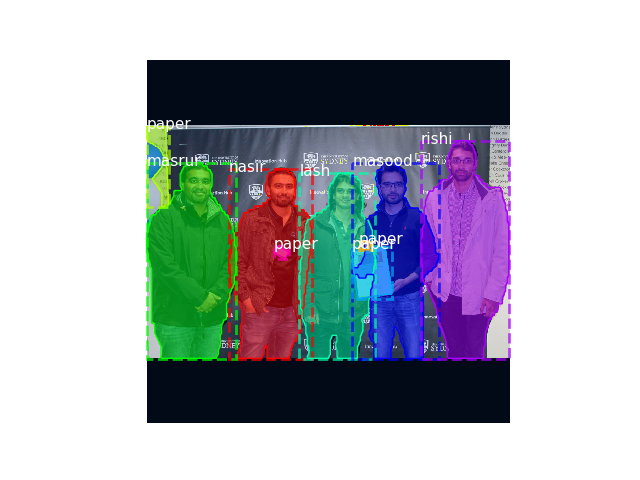

Column-wise left to right, bottom row:
coco-segmentation (1, 20)


In [5]:
def display_from_inputs(inputs, **kwargs):
    from mrcnn.visualize import display_instances
    from mrcnn.utils import unmold_mask
    print(inputs[4].shape)
    N = np.argwhere(inputs[4][0] == 0)[0][0]
    image, image_meta = inputs[0][0], inputs[1][0]
    rpn_match, rpn_bbox = inputs[2][0], inputs[3][0]
    gt_class_ids, gt_boxes, gt_masks = inputs[4][0, :N], inputs[5][0, :N], inputs[6][0, ..., :N]

    masks = np.array([
        unmold_mask(gt_masks[..., idx], gt_boxes[idx], image.shape)
        for idx in range(N)]).transpose([1, 2, 0])

    display_instances(
        ARGS['postprocess_data'](image), gt_boxes, masks, gt_class_ids, ARGS['class_names'], **kwargs)
        
def view_dataset_samples(num_rows=2, num_cols=2):
    plt.figure()
    print("Column-wise left to right, bottom row:")
    for i, (name, ds) in enumerate(DATASET.items()):
        print(name, end=' ')
        for j, (inputs, targets) in enumerate(ARGS['pipeline'](ds.mrcnn_generator(shuffle=True))):
            ax = plt.subplot(num_rows, num_cols, num_cols * j + i + 1)
            display_from_inputs(inputs, ax=ax)
#             plt.title(', '.join([ARGS['caption_map'].inv[int(cap_id)] for cap_id in np.argwhere(label)]))
            plt.axis('off')
            if j + 1 == num_rows:
                break

view_dataset_samples(num_rows=1, num_cols=1)